In [1]:
import glob
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplhep as hep
import yahist

from tqdm import tqdm

plt.style.use(hep.style.CMS)
plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

TAG = "xbbbins"
PLOTS_DIR = f"/home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_{TAG}"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [2]:
babies = glob.glob(f"../analysis/studies/qcdcorr/output_{TAG}/Run2/*.root")
sig_babies = [b for b in babies if "VBSVVH" in b]
data_babies = [b for b in babies if "data" in b]
bkg_babies = [b for b in babies if not b in sig_babies and not b in data_babies]

print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/qcdcorr/output_xbbbins/Run2/VBSVVH.root
Background:
../analysis/studies/qcdcorr/output_xbbbins/Run2/TTHad.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/SingleTop.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/QCD.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/Bosons.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/TTH.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/TTW.root
../analysis/studies/qcdcorr/output_xbbbins/Run2/TT1L.root
Data:
../analysis/studies/qcdcorr/output_xbbbins/Run2/data.root


In [3]:
def get_hists_from3D(root_files, ignore=[], colors=None):
    hists = {}
    
    if not colors:
        colors = [
            "#364b9a", "#e8eff6", "#6ea5cd", "#97cae1", "#c2e4ee",
            "#eaeccc", "#feda8a", "#fdb366", "#f67e4b", "#dd3c2d"
        ]

    for file_i, root_file in enumerate(root_files):
        with uproot.open(root_file) as f:
            for key in f.keys():
                name = key.split(";")[0] # keys have an annoying ';1' at the end
                if name in ignore:
                    continue
                else:
                    hist_root = f[name]
                    hist_values = hist_root.values()
                    hist_errors = hist_root.errors()
                    x_edges = hist_root.axis(0).edges() # pT bins
                    y_edges = hist_root.axis(1).edges() # eta or xbb bins
                    z_edges = hist_root.axis(2).edges() # ParticleNet score bins
                    n_xbins, n_ybins, n_zbins = hist_values.shape
                    for xbin_i in range(n_xbins):
                        for ybin_i in range(n_ybins):
                            hist_name = f"{name}_xbin{xbin_i}_ybin{ybin_i}"                        
                            hist = yahist.Hist1D.from_bincounts(
                                hist_values[xbin_i,ybin_i,:], 
                                bins=z_edges, 
                                errors=hist_errors[xbin_i,ybin_i,:],
                                color=colors[file_i],
                                label=f"{root_file.split('/')[-1].replace('.root', '')}",
                                metadata={
                                    "x_edges": (x_edges[xbin_i], x_edges[xbin_i+1]),
                                    "y_edges": (y_edges[ybin_i], y_edges[ybin_i+1])
                                }
                            )
                            if hist_name in hists:
                                if np.sum(hist.counts) > np.sum(hists[hist_name][-1].counts):
                                    hists[hist_name].append(hist)
                                else:
                                    hists[hist_name].insert(0, hist)
                            else:
                                hists[hist_name] = [hist]
    return hists

In [4]:
to_ignore = [
    "tree",
    "AllMerged_SelectVBSJets__hbbfatjet_xbbscore2D", 
    "AllMerged_SelectVBSJets__ld_vqqfatjet_xbbscore2D", 
    "AllMerged_SelectVBSJets__tr_vqqfatjet_xbbscore2D",
    "AllMerged_SelectVBSJets__hbbfatjet_xvqqscore2D", 
    "AllMerged_SelectVBSJets__ld_vqqfatjet_xvqqscore2D", 
    "AllMerged_SelectVBSJets__tr_vqqfatjet_xvqqscore2D",
    "AllMerged_SelectVBSJets__hbbfatjet_xwqqscore2D", 
    "AllMerged_SelectVBSJets__ld_vqqfatjet_xwqqscore2D", 
    "AllMerged_SelectVBSJets__tr_vqqfatjet_xwqqscore2D",
    "SemiMerged_SelectVBSJets__hbbfatjet_xbbscore2D", 
    "SemiMerged_SelectVBSJets__ld_vqqfatjet_xbbscore2D", 
    "SemiMerged_SelectVBSJets__tr_vqqfatjet_xbbscore2D",
    "SemiMerged_SelectVBSJets__hbbfatjet_xvqqscore2D", 
    "SemiMerged_SelectVBSJets__ld_vqqfatjet_xvqqscore2D", 
    "SemiMerged_SelectVBSJets__tr_vqqfatjet_xvqqscore2D",
    "SemiMerged_SelectVBSJets__hbbfatjet_xwqqscore2D", 
    "SemiMerged_SelectVBSJets__ld_vqqfatjet_xwqqscore2D", 
    "SemiMerged_SelectVBSJets__tr_vqqfatjet_xwqqscore2D"
]
bkg_hists = get_hists_from3D(bkg_babies, ignore=to_ignore)
qcd_hists = get_hists_from3D([b for b in bkg_babies if "QCD" in b], ignore=to_ignore)
nonqcd_hists = get_hists_from3D([b for b in bkg_babies if "QCD" not in b], ignore=to_ignore)
sig_hists = get_hists_from3D(sig_babies, ignore=to_ignore, colors=["red"])
data_hists = get_hists_from3D(data_babies, ignore=to_ignore, colors=["black"])

qcd_hists = {k: h[0] for k, h in qcd_hists.items()}
sig_hists = {k: h[0] for k, h in sig_hists.items()}
data_hists = {k: h[0] for k, h in data_hists.items()}

In [5]:
def plot_pdf_comp(numer_hist, denom_hist, error_hist=False, logy=False):
    
    # Set up figure/axes
    fig = plt.figure()
    gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
    hist_axes = fig.add_subplot(gs[0])
    ratio_axes = fig.add_subplot(gs[1])

    if logy:
        hist_axes.set_yscale("log", nonpositive="clip")
            
    # Get ratio
    ratio_hist = numer_hist/denom_hist

    # Plot ratio hist
    ratio_hist.plot(ax=ratio_axes, errors=True, color="k", zorder=1.2, fmt=".")
    
    if error_hist:
        # Plot denom hist
        denom_hist.plot(
            ax=hist_axes, errors=True, color="b", 
            label=f"AllMerged [{denom_hist.metadata['n_events']:.1f} events]", fmt="o"
        )
        # Plot numer hist
        numer_hist.plot(
            ax=hist_axes, errors=True, color="r", 
            label=f"SemiMerged [{numer_hist.metadata['n_events']:.1f} events]", fmt="^"
        )
    else:
        # Plot denom hist
        denom_hist.plot(
            ax=hist_axes, color="b", label=f"AllMerged [{denom_hist.metadata['n_events']:.1f} events]"
        )
        # Plot MC error on denom histogram
        err_points = np.repeat(denom_hist.edges, 2)[1:-1]
        err_high = np.repeat(denom_hist.counts + denom_hist.errors, 2)
        err_low = np.repeat(denom_hist.counts - denom_hist.errors, 2)
        hist_axes.fill_between(
            err_points, err_high, err_low,
            step="mid",
            hatch="///////",
            facecolor="none",
            edgecolor=(0, 0, 1, 0.25),
            linewidth=0.0,
            linestyle="-",
            zorder=1.1,
            label=u"MC unc. [stat]"
        )
    
        # Plot numer hist
        numer_hist.plot(
            ax=hist_axes, color="r", label=f"SemiMerged [{numer_hist.metadata['n_events']:.1f} events]"
        )
        # Plot MC error on numer histogram
        err_points = np.repeat(numer_hist.edges, 2)[1:-1]
        err_high = np.repeat(numer_hist.counts + numer_hist.errors, 2)
        err_low = np.repeat(numer_hist.counts - numer_hist.errors, 2)
        hist_axes.fill_between(
            err_points, err_high, err_low,
            step="mid",
            hatch="///////",
            facecolor="none",
            edgecolor=(1, 0, 0, 0.25),
            linewidth=0.0,
            linestyle="-",
            zorder=1.1,
            label=u"MC unc. [stat]"
        )
    
    # Plot CMS label
    hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=hist_axes);
    
    # Format hist axes
    hist_axes.set_ylabel("a.u.")
    hist_axes.set_xticklabels([])
    hist_axes.legend(fontsize=16)
    hist_axes.margins(x=0)
    
    # Format ratio axes
    ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
    ratio_axes.legend().remove()
    ratio_axes.set_ylabel("Semi/All")
    ratio_axes.set_ylim([0, 2])
    
    return hist_axes, ratio_axes

def collect_hists(which_hists, score):
    if which_hists == "bkg":
        all_hists = bkg_hists
    elif which_hists == "qcd":
        all_hists = qcd_hists
    elif which_hists == "data":
        all_hists = data_hists
    elif which_hists == "data_minus_nonqcd":
        all_hists = data_hists
    elif which_hists == "nonqcd":
        all_hists = nonqcd_hists
    elif which_hists == "nonqcd_frac":
        all_hists = nonqcd_hists
    else:
        return
    
    # Collect histograms
    pdf_1D_hists = {}
    pdf_2D_hists = {}
    for name, h in all_hists.items():
        if ("3Dalt" in name or score == "xbb") and score in name:
            if which_hists == "bkg" or which_hists == "nonqcd" or which_hists == "nonqcd_frac":
                # Sum all histograms
                hist = h[0].copy()
                for _h in h[1:]:
                    hist += _h
            else:
                hist = h
                if which_hists == "data_minus_nonqcd":
                    nonqcd = nonqcd_hists[name][0].copy()
                    for _h in nonqcd_hists[name][1:]:
                        nonqcd += _h
                    hist -= nonqcd
                
            # Get channel (SemiMerged or AllMerged)
            channel = name.split("_")[0]
            if channel not in pdf_1D_hists:
                pdf_1D_hists[channel] = {}
            if channel not in pdf_2D_hists:
                pdf_2D_hists[channel] = {}
                
            # Get x or x-y bin (string)
            xbin_str, ybin_str = name.split("_")[-2:]
            xybin_str = f"{xbin_str}_{ybin_str}"
            
            # Put hist into 1D collection
            if xbin_str in pdf_1D_hists[channel]:
                pdf_1D_hists[channel][xbin_str] += hist
            else:
                pdf_1D_hists[channel][xbin_str] = hist

            # Put hist into 2D collection
            if xybin_str in pdf_2D_hists[channel]:
                pdf_2D_hists[channel][xybin_str] += hist
            else:
                pdf_2D_hists[channel][xybin_str] = hist
                    
    return pdf_1D_hists, pdf_2D_hists

def plot_all_pdfs(which_hists, score, bintype, logy=False, rebin=0, tag=None, ylim=None, xbin_label="x",
                  ybin_label="y"):
    
    pdf_1D_hists, pdf_2D_hists = collect_hists(which_hists, score)
    if which_hists == "nonqcd_frac":
        denom_1D_hists, denom_2D_hists = collect_hists("data", score)

    # Normalize and optionally rebin histograms
    if bintype == "1D":
        for channel, hists in pdf_1D_hists.items():
            for bin_str, hist in hists.items():
                new_hist = hist.copy()
                new_hist.metadata["n_events"] = np.sum(hist.counts)
                if rebin > 0:
                    new_hist = new_hist.rebin(rebin)
                    if which_hists == "nonqcd_frac":
                        denom_1D_hists[channel][bin_str] = denom_1D_hists[channel][bin_str].rebin(rebin)
                if which_hists == "nonqcd_frac":
                    new_hist /= denom_1D_hists[channel][bin_str]
                else:
                    new_hist = new_hist.normalize()
                pdf_1D_hists[channel][bin_str] = new_hist
                
        pdf_hists = pdf_1D_hists
    elif bintype == "2D":
        for channel, hists in pdf_2D_hists.items():
            for bin_str, hist in hists.items():
                new_hist = hist.copy()
                new_hist.metadata["n_events"] = np.sum(hist.counts)
                if rebin > 0:
                    new_hist = new_hist.rebin(rebin)
                    if which_hists == "nonqcd_frac":
                        denom_2D_hists[channel][bin_str] = denom_2D_hists[channel][bin_str].rebin(rebin)
                if which_hists == "nonqcd_frac":
                    new_hist /= denom_2D_hists[channel][bin_str]
                else:
                    new_hist = new_hist.normalize()
                pdf_2D_hists[channel][bin_str] = new_hist
                
        pdf_hists = pdf_2D_hists
    else:
        return
            
    if bintype == "1D":
        pdf_hists = pdf_1D_hists
    elif bintype == "2D":
        pdf_hists = pdf_2D_hists
    
    # Plot all histograms
    for bin_str in tqdm(pdf_hists["AllMerged"], desc=f"plotting {which_hists} {score} ({bintype}) histograms"):
        numer_hist = pdf_hists["SemiMerged"][bin_str]
        denom_hist = pdf_hists["AllMerged"][bin_str]

        hist_axes, ratio_axes = plot_pdf_comp(
            numer_hist, 
            denom_hist, 
            error_hist=("data" in which_hists), 
            logy=logy
        )
        
        if ylim:
            hist_axes.set_ylim(top=ylim)

        if score == "xbb":
            ratio_axes.set_xlabel("ParticleNet Xbb Score")
        elif score == "xvqq":
            ratio_axes.set_xlabel("ParticleNet XVqq Score")
        elif score == "xwqq":
            ratio_axes.set_xlabel("ParticleNet XWqq Score")

        # Plot bin edge information from numer hist
        x_low, x_high = numer_hist.metadata["x_edges"]
        if bintype == "1D":
            hist_axes.text(
                0.03, 0.97, 
                r"$XLOW \leq XBINLABEL < XHIGH$".replace("XBINLABEL", xbin_label).replace("XLOW", str(x_low)).replace("XHIGH", str(x_high)),
                ha="left", va="top",
                fontsize=16,
                transform=hist_axes.transAxes
            )
        elif bintype == "2D":
            y_low, y_high = numer_hist.metadata["y_edges"]
            hist_axes.text(
                0.03, 0.97, 
                (r"$YLOW \leq YBINLABEL < YHIGH$".replace("YBINLABEL", ybin_label).replace("YLOW", str(y_low)).replace("YHIGH", str(y_high))
                 + "\n"
                 + r"$XLOW \leq XBINLABEL < XHIGH$".replace("XBINLABEL", xbin_label).replace("XLOW", str(x_low)).replace("XHIGH", str(x_high))),
                ha="left", va="top",
                fontsize=16,
                transform=hist_axes.transAxes
            )
        
        # Save file
        plot_file = f"{PLOTS_DIR}/{which_hists}_{score}_{bintype}_pdf_{bin_str}.pdf"
        if tag:
            plot_file = plot_file.replace(".pdf", f"_{tag}.pdf")
        plt.savefig(plot_file, bbox_inches="tight")
        plt.savefig(plot_file.replace(".pdf", ".png"), bbox_inches="tight")
        plt.close()

In [6]:
plot_all_pdfs("data_minus_nonqcd", "xbb", "1D", rebin=20, xbin_label="p_T")
plot_all_pdfs("data_minus_nonqcd", "xwqq", "2D", rebin=20, xbin_label="p_T", ybin_label="Xbb")

plotting data_minus_nonqcd xwqq (2D) histograms: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:48<00:00,  1.80s/it]


In [7]:
plot_all_pdfs("nonqcd_frac", "xbb", "1D", rebin=50, xbin_label="p_T")
plot_all_pdfs("nonqcd_frac", "xwqq", "2D", rebin=50, xbin_label="p_T", ybin_label="Xbb")

plotting nonqcd_frac xwqq (2D) histograms: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:52<00:00,  1.87s/it]


In [4]:
with uproot.open("../analysis/data/vbsvvhjets_sfs/qcd_pnet_pdfs.root") as f:
    for name in ["ParticleNet_Xbb_PDF_2D", "ParticleNet_XVqq_PDF_2D", "ParticleNet_XWqq_PDF_2D"]:
        hist_root = f[name]
        hist_values = hist_root.values()
        hist_errors = hist_root.errors()
        pt_edges = hist_root.axis(0).edges()
        score_edges = hist_root.axis(1).edges()
        n_ptbins, n_scorebins = hist_values.shape
        for ptbin_i in range(n_ptbins):
#             fig, axes = plt.subplots()

            fig = plt.figure()
            gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
            axes = fig.add_subplot(gs[0])
            ratio_axes = fig.add_subplot(gs[1])

            hist_name = f"{name}_ptbin{ptbin_i}"                        
            hist = yahist.Hist1D.from_bincounts(
                hist_values[ptbin_i,:], 
                bins=score_edges, 
                errors=hist_errors[ptbin_i,:],
                color="r",
                metadata={
                    "pt_edges": (pt_edges[ptbin_i], pt_edges[ptbin_i+1]),
                }
            )
            pt_low, pt_high = pt_edges[ptbin_i:ptbin_i+2]
            
            hist = hist.rebin(20).normalize()
            hist.plot(ax=axes, errors=True, fmt="^")
            
            axes.text(
                0.03, 0.97, 
                r"$PTLOW \leq p_T < PTHIGH$ GeV".replace("PTLOW", str(pt_low)).replace("PTHIGH", str(pt_high)),
                ha="left", va="top",
                fontsize=16,
                transform=axes.transAxes
            )
            
            axes.set_ylabel("a.u.")
            
            if "Xbb" in name:
                ratio_axes.set_xlabel("ParticleNet Xbb Score")
            elif "XVqq" in name:
                ratio_axes.set_xlabel("ParticleNet XVqq Score")
            elif "XWqq" in name:
                ratio_axes.set_xlabel("ParticleNet XWqq Score")
                
            # Format hist axes
            axes.set_xticklabels([])
            axes.margins(x=0)

            # Format ratio axes
            ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
#             ratio_axes.set_ylabel("")
            ratio_axes.set_ylim([0, 2])
                
            if "XVqq" in name:
                axes.set_ylim(top=0.04)
            
            # Plot CMS label
            hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes);
            
            # Save file
            plot_file = f"{PLOTS_DIR}/{name}_TEST_ptbin{ptbin_i}.pdf"
            print(f"Saved {plot_file}")
            plt.savefig(plot_file, bbox_inches="tight")
            plt.savefig(plot_file.replace(".pdf", ".png"), bbox_inches="tight")
            plt.close()

Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin0.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin1.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin2.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin3.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin4.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin5.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin6.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin7.pdf
Saved /home/users/jguiang/public_html/vbsvvhjets_plots/qcdcorr_xwqq/ParticleNet_Xbb_PDF_2D_TEST_ptbin8.pdf
Saved /home/users/jguiang/public_html

In [4]:
def plot(name, logy=True, rebin=0, save=False):

    fig = plt.figure()
    gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
    hist_axes = fig.add_subplot(gs[0])
    ratio_axes = fig.add_subplot(gs[1])

    if logy:
        hist_axes.set_yscale("log", nonpositive="clip")

    # Get total bkg hist
    total_bkg_hist = bkg_hists[name][0].copy()
    for h in bkg_hists[name][1:]:
        total_bkg_hist += h
    
    # Get data hist
    data_hist = data_hists[name]
    
    if rebin > 0:
        total_bkg_hist = total_bkg_hist.rebin(rebin)
        data_hist = data_hist.rebin(rebin)

    # Plot stacked bkg, total bkg, and data
    if rebin > 0:
        yahist.utils.plot_stack([h.rebin(rebin) for h in bkg_hists[name]], ax=hist_axes, histtype="stepfilled")
    else:
        yahist.utils.plot_stack(bkg_hists[name], ax=hist_axes, histtype="stepfilled")
        
    total_bkg_hist.plot(ax=hist_axes, color="k", alpha=0.75, label="Total bkg", zorder=1)
    data_hist.plot(ax=hist_axes, errors=True, fmt=".", zorder=1.2)

    # Get data/MC ratio
    ratio_hist = data_hist/total_bkg_hist
    # Set ratio errors to data relative stat error times the ratio
    data_counts = data_hist.counts.copy()
    data_counts[data_counts == 0] = 1e-12
    ratio_hist._errors = (data_hist.errors/data_counts)*ratio_hist.counts

    # Plot ratio hist
    ratio_hist.plot(ax=ratio_axes, errors=True, color="k", zorder=1.2, fmt=".")

    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    bkg_counts = total_bkg_hist.counts.copy()
    bkg_counts[bkg_counts == 0] = 1e-12
    err_points = np.repeat(total_bkg_hist.edges, 2)[1:-1]
    err_high = np.repeat(1 + total_bkg_hist.errors/bkg_counts, 2)
    err_low = np.repeat(1 - total_bkg_hist.errors/bkg_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=(0.85, 0.85, 0.85),
        linewidth=0.0,
        linestyle="-",
        zorder=1.1
    )
    
    # Plot MC error on histogram
    err_high = np.repeat(bkg_counts + total_bkg_hist.errors, 2)
    err_low = np.repeat(bkg_counts - total_bkg_hist.errors, 2)
    hist_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=(0.85, 0.85, 0.85),
        linewidth=0.0,
        linestyle="-",
        zorder=1.1,
        label=u"MC unc. [stat]"
    )
    
    # Get pt, eta bin edge information from data hist
    pt_low, pt_high = data_hist.metadata["pt_edges"]
    eta_low, eta_high = data_hist.metadata["eta_edges"]
    hist_axes.text(
        0.97, 0.97, 
        (r"$PTLOW \leq p_T < PTHIGH$ GeV".replace("PTLOW", str(pt_low)).replace("PTHIGH", str(pt_high))
         +"\n"
         +r"$ETALOW \leq |\eta| < ETAHIGH$".replace("ETALOW", str(eta_low)).replace("ETAHIGH", str(eta_high))),
        ha="right", va="top",
        fontsize=16,
        transform=hist_axes.transAxes
    )

    # Format axes
    hist_axes.set_xticklabels([])
    hist_axes.legend(fontsize=12)
    ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
    ratio_axes.legend().remove()
    if "hbb" in name:
        ratio_axes.set_xlabel("ParticleNet Xbb score")
    elif "vqq" in name:
        ratio_axes.set_xlabel("ParticleNet XVqq score")
    ratio_axes.set_ylabel("data/MC")
    ratio_axes.set_ylim([0, 2])

    hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=hist_axes);
    
    if save:
        plot_file = f"{PLOTS_DIR}/{name}.pdf"
#         print(f"Wrote plot to {plot_file}")
        plt.savefig(plot_file, bbox_inches="tight")
        plt.savefig(plot_file.replace(".pdf", ".png"), bbox_inches="tight")
        plt.close()
    return

In [8]:
print(list(bkg_hists.keys())[:10])

['AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin0_etabin0', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin0_etabin1', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin0_etabin2', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin0_etabin3', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin0_etabin4', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin1_etabin0', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin1_etabin1', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin1_etabin2', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin1_etabin3', 'AllMerged_SelectVBSJets__hbbfatjet_xbbscore_ptbin1_etabin4']


In [6]:
for hist_name in tqdm(bkg_hists.keys()):
    plot(hist_name, logy=True, rebin=20, save=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [19:27<00:00,  3.34s/it]


In [3]:
def get_hists(root_files, ignore=[], colors=None):
    hists = {}
    
    if not colors:
        colors = [
            "#364b9a", "#e8eff6", "#6ea5cd", "#97cae1", "#c2e4ee",
            "#eaeccc", "#feda8a", "#fdb366", "#f67e4b", "#dd3c2d"
        ]

    for file_i, root_file in enumerate(root_files):
        with uproot.open(root_file) as f:
            for key in f.keys():
                name = key.split(";")[0] # keys have an annoying ';1' at the end
                if name in ignore:
                    continue
                else:
                    root_hist = f[name]
                    hist = yahist.Hist1D.from_bincounts(
                        root_hist.values(), 
                        bins=root_hist.axis().edges(), 
                        errors=root_hist.errors(),
                        color=colors[file_i],
                        label=f"{root_file.split('/')[-1].replace('.root', '')}"
                    )
                    if name in hists:
                        if np.sum(hist.counts) > np.sum(hists[name][-1].counts):
                            hists[name].append(hist)
                        else:
                            hists[name].insert(0, hist)
                    else:
                        hists[name] = [hist]
    return hists

In [4]:
bkg_hists = get_hists(bkg_babies, ignore=["tree"])
sig_hists = get_hists(sig_babies, ignore=["tree"], colors=["red"])
data_hists = get_hists(data_babies, ignore=["tree"], colors=["black"])

In [5]:
print("\n".join(bkg_hists.keys()))

SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0_etabin0
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0_etabin1
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0_etabin2
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0_etabin3
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0_etabin4
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin0etabinOF
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1_etabin0
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1_etabin1
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1_etabin2
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1_etabin3
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1_etabin4
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin1etabinOF
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2_etabin0
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2_etabin1
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2_etabin2
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2_etabin3
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2_etabin4
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin2etabinOF
SemiMerged_Geq4Jets__hbbfatjet_score_ptbin3_etabin0
SemiMerged_G

In [6]:
sig_hists = {k: h[0] for k, h in sig_hists.items()}
data_hists = {k: h[0] for k, h in data_hists.items()}

In [29]:
total = 0
for hname in bkg_hists:
    if "hbbfatjet" in hname:
        total += sum([np.sum(h.counts) for h in bkg_hists[hname]])
                     
total

39532556.02177321

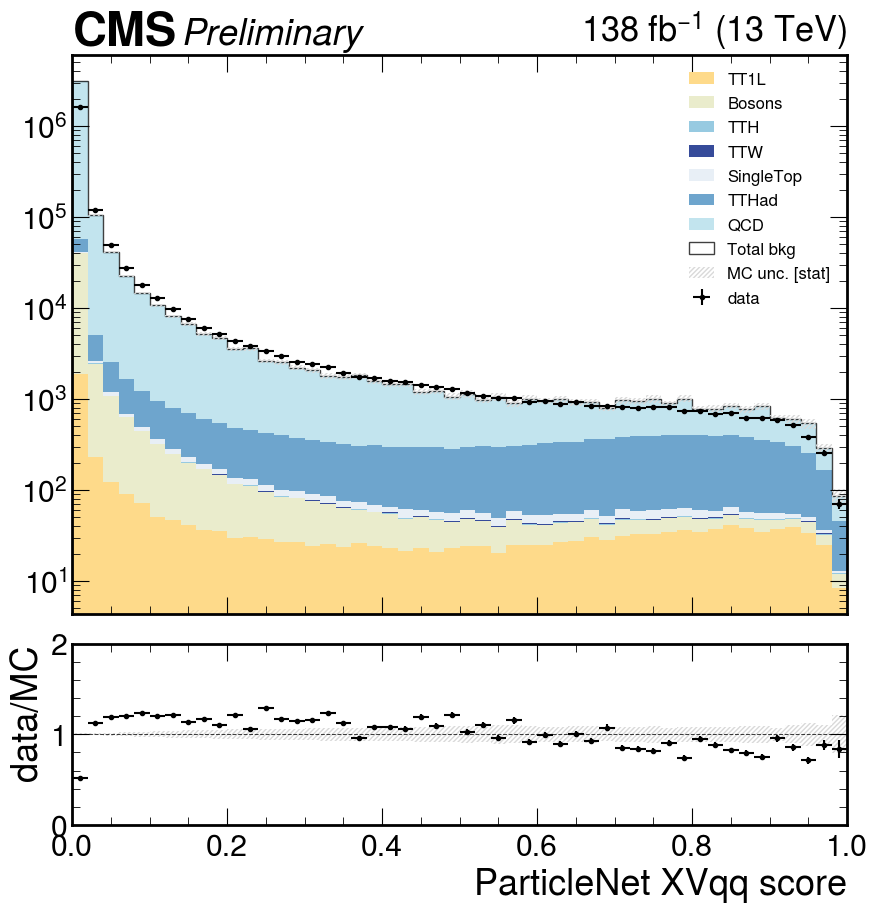

In [40]:
test = plot("SemiMerged_Geq4Jets__vqqfatjet_score_ptbin3_etabin2", logy=True, rebin=20)

In [12]:
import hist
hout = hist.Hist(hist.axis.Variable(test.edges), storage=hist.storage.Weight())
hout[...] = np.stack([test.counts, test.errors**2], axis=-1)

In [15]:
hout

Hist(Variable(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ]), label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=149.898, variance=3.50789)

In [17]:
with uproot.recreate("test.root") as f:
    f["test"] = hout